In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import entropy
from itertools import product
import random
from collections import Counter
import os
import numpy as np
from scipy.ndimage import gaussian_filter1d
import seaborn as sns


In [52]:


# Create a 3x3 grid graph
G = nx.grid_2d_graph(3, 3)
G = nx.convert_node_labels_to_integers(G, first_label=1)

# Function to generate all possible paths of a given length
def generate_paths(graph, start_node, length):
    if length == 0:
        return [[start_node]]
    paths = []
    for neighbor in graph.neighbors(start_node):
        for path in generate_paths(graph, neighbor, length - 1):
            paths.append([start_node] + path)
    return paths

# Create a nested dictionary to store the dataframes
df_dict = {}

# Iterate over all nodes to create dataframes
for node in G.nodes:
    df_dict[node] = {}
    for length in range(1, 4):  # Assuming we want paths of length 1 to 4
        path_list = generate_paths(G, node, length)
        df = pd.DataFrame({'paths': path_list, 'counts': [0] * len(path_list)})
        df_dict[node][length] = df

# # Print the dataframes
# for node, dfs in df_dict.items():
#     print(f"Node {node}:")
#     for length, df in dfs.items():
#         print(f"  {length}-step paths:")
#         print(df)


In [54]:


def simulate_diffusion(num_steps=100, start_node=None):
    """
    Simulates a random diffusion (random walk) on a 3x3 grid (nodes labeled 1 to 9)
    for a given number of steps.
    
    The grid is arranged as follows:
      1   2   3
      4   5   6
      7   8   9

    Each node is connected to its immediate neighbors (up, down, left, right) where applicable.
    
    Parameters:
        num_steps (int): Number of steps for the diffusion process.
        start_node (int or None): Starting node label (1-9). If None, a random node is chosen.
    
    Returns:
        list: Sequence of node positions visited over time.
    """
    # Define connectivity for the 3x3 grid
    graph = {
        1: [2, 4],        # Node 1 connects to 2 (right) and 4 (down)
        2: [1, 3, 5],     # Node 2 connects to 1 (left), 3 (right), and 5 (down)
        3: [2, 6],        # Node 3 connects to 2 (left) and 6 (down)
        4: [1, 5, 7],     # Node 4 connects to 1 (up), 5 (right), and 7 (down)
        5: [2, 4, 6, 8],  # Node 5 (center) connects to nodes 2, 4, 6, and 8
        6: [3, 5, 9],     # Node 6 connects to 3 (up), 5 (left), and 9 (down)
        7: [4, 8],        # Node 7 connects to 4 (up) and 8 (right)
        8: [5, 7, 9],     # Node 8 connects to 5 (up), 7 (left), and 9 (right)
        9: [6, 8]         # Node 9 connects to 6 (up) and 8 (left)
    }
    
    # Choose a random starting node if none is provided
    if start_node is None:
        start_node = random.choice(list(graph.keys()))
    
    current_node = start_node
    path = [current_node]
    
    # Simulate the random diffusion process
    for _ in range(num_steps):
        current_node = random.choice(graph[current_node])
        path.append(current_node)
    
    return path

# Parameters for the simulation
num_steps = 50  # Number of diffusion steps
start_node = 5  # Start at the center of the grid

# Run the simulation
diffusion_path = simulate_diffusion(num_steps=num_steps, start_node=start_node)

# Print the random diffusion path
print("Random diffusion path over time:")
print(diffusion_path)


Random diffusion path over time:
[5, 6, 3, 6, 5, 8, 5, 2, 5, 4, 1, 2, 1, 2, 3, 6, 3, 2, 1, 2, 1, 4, 5, 2, 5, 4, 1, 4, 1, 4, 5, 6, 9, 8, 9, 8, 5, 8, 9, 8, 9, 8, 7, 4, 1, 2, 3, 2, 3, 6, 9]


In [55]:
def load_and_clean_rois(rois_path):
    # Load the ROIs data from the CSV file
    rois_df = pd.read_csv(rois_path)
    
    rois = rois_df['head_back'].values

    # Filter and clean the ROIs
    rois = [int(roi.split('_')[1]) for roi in rois if isinstance(roi, str) and roi[:4]=='node']
    
    # Remove consecutive duplicates
    rois = [rois[i] for i in range(len(rois)) if i == 0 or rois[i] != rois[i - 1]]

    return rois

def make_path_counts_dict(positions, mouse):

    # Create a copy of df_dict to avoid modifying the original
    df_dict_copy = {node: {length: df.copy() for length, df in lengths.items()} for node, lengths in df_dict.items()}

    # Convert positions to a string format for easier comparison
    positions_str = ','.join(map(str, positions))

    # Generate all sub-paths of lengths 1 to 4 from the positions list
    sub_paths = []
    for length in range(1, 5+1):
        for i in range(len(positions) - length + 1):
            sub_path = positions[i:i + length]
            sub_paths.append(sub_path)

    # Convert sub_paths to a string format for easier comparison
    sub_paths_str = [','.join(map(str, sub_path)) for sub_path in sub_paths]

    # Count the occurrences of each sub-path
    sub_paths_counter = Counter(sub_paths_str)

    # Iterate over the copied dictionary and update the counts
    for node, lengths in df_dict_copy.items():
        for length, df in lengths.items():
            for i, row in df.iterrows():
                path_str = ','.join(map(str, row['paths']))
                count = sub_paths_counter[path_str]
                df.at[i, 'counts'] = count

    # Create a nested dictionary called mouse and save the results structured as mouse1[node][n_steps]
    mouse1 = {node: {n_steps: df for n_steps, df in lengths.items()} for node, lengths in df_dict_copy.items()}

    # # Print the updated dataframes
    # for node, lengths in df_dict_copy.items():
    #     print(f"Node {node}:")
    #     for length, df in lengths.items():
    #         print(f"  {length}-step paths:")
    #         print(df)
    
    return mouse1

def combine_dataframes_n_steps(mouse_dict):
    # Combine the dataframes for each n_steps into a single dataframe
    combined_dfs = {n_steps: [] for n_steps in range(1, 4)}
    for node, lengths in mouse_dict.items():
        for n_steps, df in lengths.items():
            df[node] = node
            combined_dfs[n_steps].append(df)
    
    combined_dfs = {n_steps: pd.concat(dfs, ignore_index=True) for n_steps, dfs in combined_dfs.items()}
    
    return combined_dfs

def calculate_entropy_nodespecific(mouse_dict, n_steps=None):
    entropies = []
    
    if n_steps is not None:
        # Calculate entropy for a specific n_steps across all nodes
        for node, lengths in mouse_dict.items():
            if n_steps in lengths:
                counts = lengths[n_steps]['counts']
                entropies.append(entropy(counts))
        avg_entropy = np.mean(entropies) if entropies else 0
        return avg_entropy
    
    # Calculate entropy for all examples
    for node, lengths in mouse_dict.items():
        for length, df in lengths.items():
            counts = df['counts']
            entropies.append(entropy(counts))
    avg_entropy = np.mean(entropies) if entropies else 0
    
    return avg_entropy

def calculate_entropy_overall(mouse_dict):
    entropies = []
    for n_steps in mouse_dict.keys():
        counts = mouse_dict[n_steps]['counts']
        normalise_counts = counts / counts.sum()
        # entropies.append(entropy(normalise_counts))
        # Normalize by the number of possible paths
        num_possible_paths = len(mouse_dict[n_steps])
        normalised_entropy = entropy(normalise_counts) / np.log(num_possible_paths)
        entropies.append(normalised_entropy)
        # entropies.append(entropy(counts))
        print(f"Entropy for {n_steps}-step paths: {normalised_entropy:.4f}")
    avg_entropy = np.mean(entropies)
    return avg_entropy

0
{1: {1:     paths  counts
0  [1, 4]       5
1  [1, 2]       6, 2:        paths  counts
0  [1, 4, 1]       0
1  [1, 4, 7]       4
2  [1, 4, 5]       1
3  [1, 2, 1]       0
4  [1, 2, 5]       1
5  [1, 2, 3]       5, 3:            paths  counts
0   [1, 4, 1, 4]       0
1   [1, 4, 1, 2]       0
2   [1, 4, 7, 4]       1
3   [1, 4, 7, 8]       3
4   [1, 4, 5, 2]       1
5   [1, 4, 5, 4]       0
6   [1, 4, 5, 8]       0
7   [1, 4, 5, 6]       0
8   [1, 2, 1, 4]       0
9   [1, 2, 1, 2]       0
10  [1, 2, 5, 2]       0
11  [1, 2, 5, 4]       0
12  [1, 2, 5, 8]       0
13  [1, 2, 5, 6]       0
14  [1, 2, 3, 2]       0
15  [1, 2, 3, 6]       5}, 2: {1:     paths  counts
0  [2, 1]       3
1  [2, 5]       5
2  [2, 3]       7, 2:        paths  counts
0  [2, 1, 4]       3
1  [2, 1, 2]       0
2  [2, 5, 2]       0
3  [2, 5, 4]       3
4  [2, 5, 8]       1
5  [2, 5, 6]       0
6  [2, 3, 2]       0
7  [2, 3, 6]       7, 3:            paths  counts
0   [2, 1, 4, 1]       0
1   [2, 1, 4, 7]       3
2  

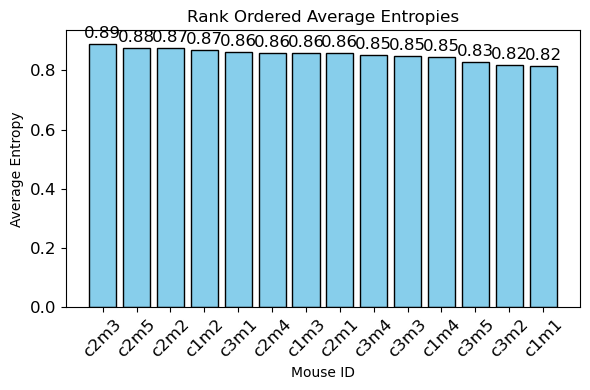

In [ ]:
exploration_folder = '/Users/AdamHarris/Desktop/cohort_10_exploration/processed'
files = os.listdir(exploration_folder)

rois_files = [f for f in files if 'ROIs' in f]
mouse_ids_rois = [f[:4] for f in rois_files]

coords_files = [f for f in files if 'cleaned_coordinates' in f]
mouse_ids_coords = [f[:4] for f in coords_files]


entropies = {}

for ind, roi_filename in enumerate(rois_files):
    mouse_id = mouse_ids_rois[ind]
    rois_path = os.path.join(exploration_folder, roi_filename)
    positions = load_and_clean_rois(rois_path)
    mouse_paths = make_path_counts_dict(positions, mouse_id)
    mouse_paths_combined = combine_dataframes_n_steps(mouse_paths)
    avg_entropy_all = calculate_entropy_overall(mouse_paths_combined)
    print(f"Average entropy across all examples for mouse {mouse_id}: {avg_entropy_all}")
    entropies[mouse_id] = avg_entropy_all



# Replace nan values with a very small number
entropies_cleaned = {k: (v if not np.isnan(v) else -np.inf) for k, v in entropies.items()}

# Sort the entropies
sorted_entropies = sorted(entropies_cleaned.items(), key=lambda item: item[1], reverse=True)

mouse_ids_sorted = [x[0] for x in sorted_entropies]

# Plot the average entropies
plt.figure(figsize=(6, 4))
bars = plt.bar(mouse_ids_sorted, [x[1] for x in sorted_entropies], color='skyblue', edgecolor='black')
plt.xlabel('Mouse ID', fontsize=10)
plt.ylabel('Average Entropy', fontsize=10)
plt.title('Rank Ordered Average Entropies', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()
    


In [ ]:

def smooth_and_calculate_scalar_derivatives(data_matrix, sigma=3, dt=1.0):
    # Assuming data_matrix is an nx2 array with x and y positions

    # Separate x and y columns
    x_positions = data_matrix[:, 0]
    y_positions = data_matrix[:, 1]

    # Smooth the data using 1D Gaussian filter
    x_smoothed = gaussian_filter1d(x_positions, sigma=sigma)
    y_smoothed = gaussian_filter1d(y_positions, sigma=sigma)

    
    # Calculate speeds (first derivative) and magnitudes
    vx = np.gradient(x_smoothed, dt)
    vy = np.gradient(y_smoothed, dt)
    speed = np.sqrt(vx**2 + vy**2)

    # calculate acceleration
    acceleration = np.gradient(speed, dt)
    # Combine results into a single array
    smoothed_data = np.column_stack((x_smoothed, y_smoothed, speed, acceleration))

    return smoothed_data



speeds = []

for ind, coords_filename in enumerate(coords_files):
    mouse_id = mouse_ids_coords[ind]
    coords_path = os.path.join(exploration_folder, coords_filename)
    coords = pd.read_csv(coords_path)
    coords = np.vstack([coords['head_back.x'], coords['head_back.y']]).T
    smoothed_data = smooth_and_calculate_scalar_derivatives(coords, sigma=5)
    speed = smoothed_data[:,2]
    
    speeds.append(speed)
    # Create a DataFrame to hold all speeds and corresponding mouse IDs
   
speeds_df = pd.DataFrame(speeds, index=mouse_ids_coords).T * 60 # Convert to cm/s


In [13]:
# import re
# from datetime import datetime

# # Extract datetime from filename and sort
# def extract_datetime(filename):
#     match = re.search(r'\d{4}-\d{2}-\d{2}-\d{6}', filename)
#     if match:
#         return datetime.strptime(match.group(), '%Y-%m-%d-%H%M%S')
#     return None

# # Create a list of tuples with filename, length of coords dataframe, and datetime
# file_info = []

# for ind, coords_filename in enumerate(coords_files):
#     coords_path = os.path.join(exploration_folder, coords_filename)
#     coords = pd.read_csv(coords_path)
#     file_datetime = extract_datetime(coords_filename)
#     file_info.append((coords_filename, len(coords), file_datetime))

# # Sort the list by datetime
# file_info_sorted = sorted(file_info, key=lambda x: x[2])

# print('Length of sleap outputs:')
# print('-----------------------')
# # Print the sorted filenames with the length of coords dataframe
# for info in file_info_sorted:
#     print(f"Filename: {info[0][:22]}, Length: {info[1]}")

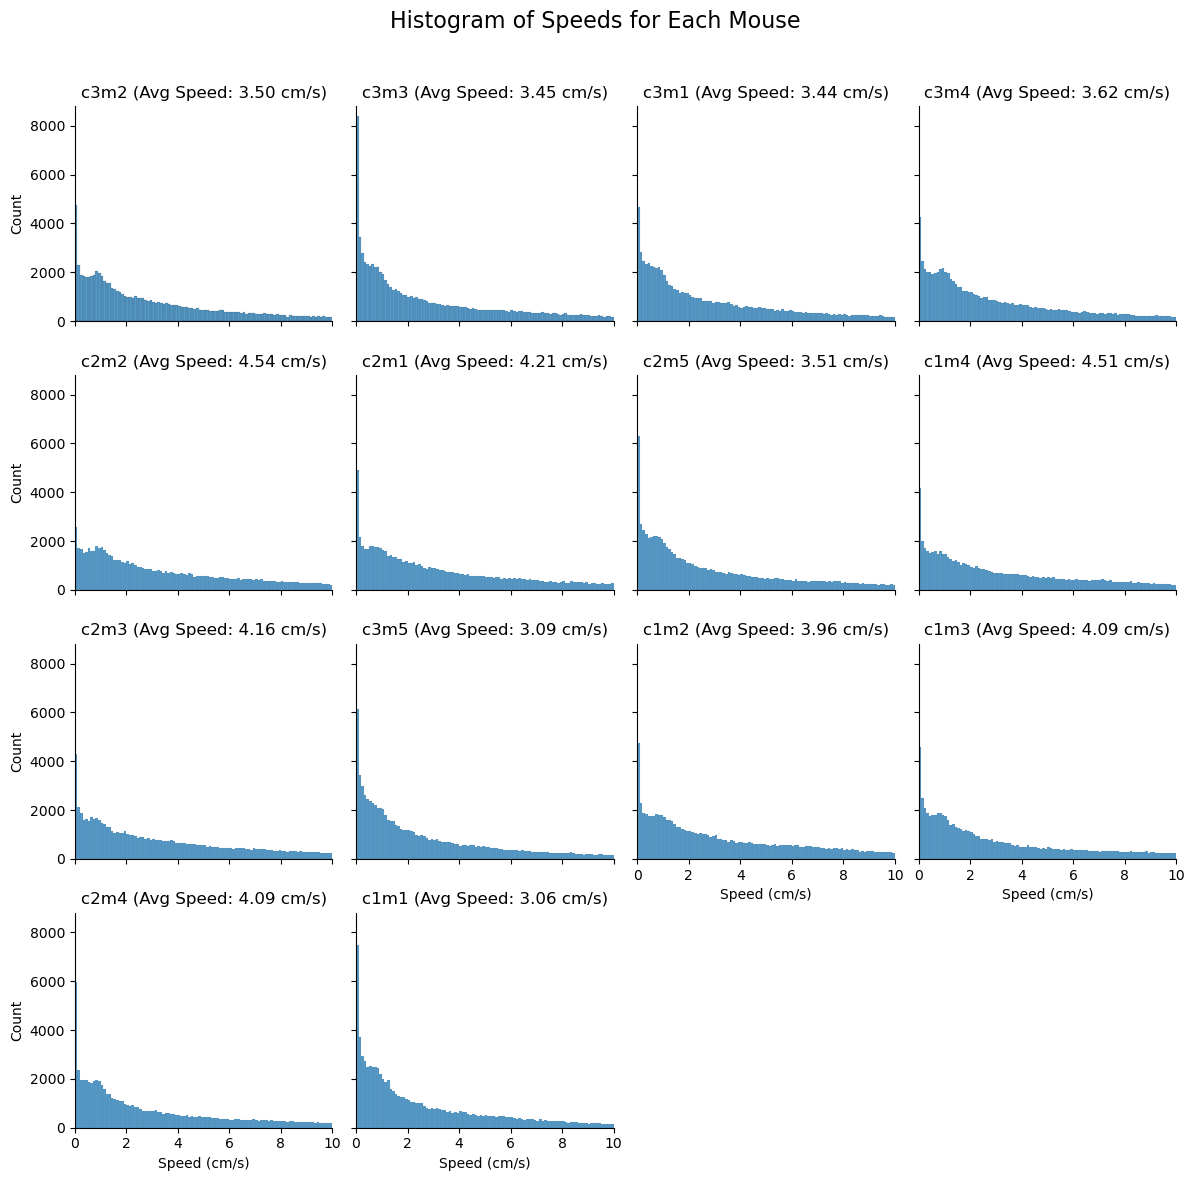

In [ ]:
# Calculate the mean speed for each mouse
mean_speeds = speeds_df.mean()

# Melt the dataframe to long format for easier plotting with seaborn
speeds_long_df = speeds_df.melt(var_name='Mouse ID', value_name='Speed')

# Create the FacetGrid for each mouse in a square grid
g = sns.FacetGrid(speeds_long_df, col='Mouse ID', col_wrap=4, aspect=1, height=3, sharex=True, sharey=True)
g.map(sns.histplot, 'Speed', binwidth=0.1)  # Set binwidth to 0.1 cm/s

# Add labels and title
g.set_axis_labels('Speed (cm/s)', 'Count')

# Set titles with average speed
for ax, mouse_id in zip(g.axes.flat, speeds_df.columns):
    ax.set_title(f'{mouse_id} (Avg Speed: {mean_speeds[mouse_id]:.2f} cm/s)')

g.fig.suptitle(f'Histogram of Speeds for Each Mouse', fontsize=16)
g.fig.subplots_adjust(top=0.90)  # Adjust the top to make room for the title

# Set x-axis limit
g.set(xlim=(0, 10))

plt.show()


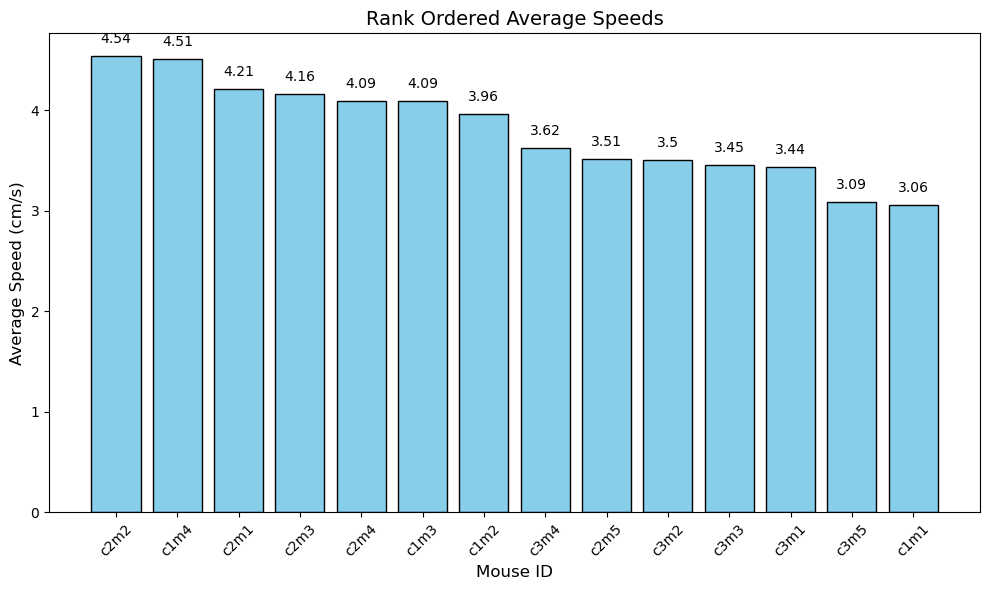

In [58]:
# Calculate the mean speed for each mouse
mean_speeds = speeds_df.mean()

# Rank order the mice by their average speed
mean_speeds_sorted = mean_speeds.sort_values(ascending=False)

# Plot the average speeds
plt.figure(figsize=(10, 6))
bars = plt.bar(mean_speeds_sorted.index, mean_speeds_sorted.values, color='skyblue', edgecolor='black')
plt.xlabel('Mouse ID', fontsize=12)
plt.ylabel('Average Speed (cm/s)', fontsize=12)
plt.title('Rank Ordered Average Speeds', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
